In [25]:
import math
import random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

from collections import deque

In [26]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

c:\ProgramData\Anaconda3\envs\tf38\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [27]:
class QNet(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_num)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

In [28]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, mini_batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.mini_batch_size = mini_batch_size
        self.reset()

    def reset(self):
        # Create a deque for each data type with set max length
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def buffer_full(self):
        return len(self.data_dict[self.data_keys[0]]) == self.buffer_size

    def data_log(self, data_name, data):
        # split tensor along batch into a list of individual datapoints
        data = data.cpu().split(1)
        # Extend the deque for data type, deque will handle popping old data to maintain buffer size
        self.data_dict[data_name].extend(data)

    def __iter__(self):
        batch_size = len(self.data_dict[self.data_keys[0]])
        batch_size = batch_size - batch_size % self.mini_batch_size

        ids = np.random.permutation(batch_size)
        ids = np.split(ids, batch_size // self.mini_batch_size)
        for i in range(len(ids)):
            batch_dict = {}
            for name in self.data_keys:
                c = [self.data_dict[name][j] for j in ids[i]]
                batch_dict[name] = torch.cat(c)
            batch_dict["batch_size"] = len(ids[i])
            yield batch_dict

    def __len__(self):
        return len(self.data_dict[self.data_keys[0]])

In [29]:
def test_agent():
    done = False
    total_reward = 0
 
    state, info = env.reset()
    observation =  torch.FloatTensor(state).unsqueeze(0)

    with torch.no_grad():
        while not done:
            q_values = q_net(observation)
            action = q_values.argmax().cpu().item()
            observation, reward, done, truncated, info = env.step(action)
            
            
            observation = torch.FloatTensor(observation).unsqueeze(0)
            total_reward += reward
            
    return total_reward

In [30]:
def dqn_update():
    for data_batch in replay_buffer:
        next_q_values = q_net(data_batch["next_states"]).detach()
        q_values = q_net(data_batch["states"])
        
        index_q_values = q_values.gather(1, data_batch["actions"])
        max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)

        expected_q_value = data_batch["rewards"] + gamma * max_next_q_values * data_batch["masks"]

        q_loss = (index_q_values - expected_q_value).pow(2).mean()

        optimizer.zero_grad()
        q_loss.backward()
        optimizer.step()

In [31]:
lr = 1e-2
gamma = 0.99
buffer_size = 2000
mini_batch_size = 32
max_steps = 15000

data_names = ["states", "next_states", "actions", "rewards", "masks"]

q_net = QNet()
optimizer = optim.Adam(q_net.parameters(), lr=lr)

replay_buffer = ReplayBuffer(data_names, buffer_size, mini_batch_size)

In [32]:
rollouts = 0
step = 0
initial_epsilon = 1
epsilon = initial_epsilon
score_logger = []

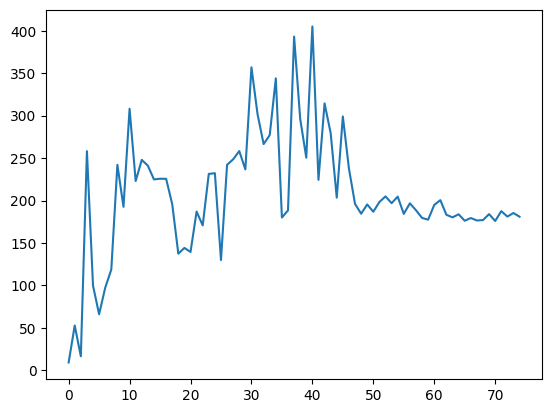

In [33]:
while step < max_steps:
    state, info = env.reset()
    observation =  torch.FloatTensor(state).unsqueeze(0)
    done = False
    
    states = []
    rewards = []
    actions = []
    masks = []

    while not done:
        states.append(observation)

        if random.random() > epsilon:
            q_values = q_net(observation)
            action = q_values.argmax().reshape(-1, 1)
        else:
            action = torch.LongTensor([env.action_space.sample()]).reshape(-1, 1)

        observation, reward, done, truncated, info = env.step(action.cpu().item())
        
        reward = torch.FloatTensor([reward]).unsqueeze(0)
        
        rewards.append(reward)
        actions.append(action)
        masks.append(torch.FloatTensor([1 - done]).unsqueeze(0))
        
        observation = torch.FloatTensor(observation).unsqueeze(0)
        step += 1
        
    states.append(observation)
    
    replay_buffer.data_log("states", torch.cat(states[:-1]))
    replay_buffer.data_log("next_states", torch.cat(states[1:]))
    replay_buffer.data_log("rewards", torch.cat(rewards))
    replay_buffer.data_log("actions", torch.cat(actions))
    replay_buffer.data_log("masks", torch.cat(masks))

    if replay_buffer.buffer_full():
        dqn_update()

        if rollouts % 2 == 0:
            new_lr = max(1e-4, ((max_steps - step)/max_steps) * lr)
            epsilon = max(0.2, ((max_steps - step)/max_steps) * initial_epsilon)
            
            optimizer.param_groups[0]["lr"] = new_lr

            score_logger.append(np.mean([test_agent() for _ in range(10)]))
            clear_output(True)
            plt.plot(score_logger)
            plt.show()
    rollouts +=1

env.close()

In [38]:
def visualize_agent(agent, env, n_episodes=5):
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()
        done = False
        score = 0
        while not done:
            env.render()
            q_values = agent(observation)
            action = q_values.argmax().cpu().item()

            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            score += reward
            if done:
                break
        print(f"Episode {i_episode}\tScore: {score}")
    env.close()

In [41]:
env = gym.make('CartPole-v1', render_mode="human")
visualize_agent(q_net, env)

Episode 1	Score: 8.0
Episode 2	Score: 9.0
Episode 3	Score: 9.0
Episode 4	Score: 10.0
Episode 5	Score: 9.0
